In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('HAM10000_metadata.csv')
print(len(df))
df.head()


10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Check null values, fill with mean

In [9]:
df.isnull().sum()
df['age'] = df['age'].fillna(df['age'].mean())

Check for class imbalance

<BarContainer object of 7 artists>

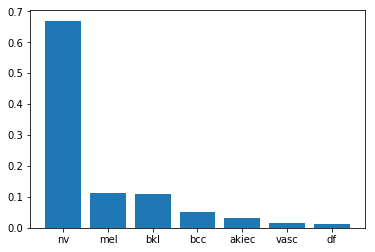

In [10]:
plt.bar(df['dx'].value_counts().index, df['dx'].value_counts() / len(df))

Next we get the image data from the dataframe, resize it to 100x100 by cropping and fitting and split into train, val and test. We import the reshaped data for convenience. 

In [11]:
import numpy as np

data_dir = 'prepared_data_100_100'
x_train = np.load(data_dir + '/x_im_train.npy')
x_test = np.load(data_dir + '/x_im_test.npy')
y_train = np.load(data_dir + '/y_train.npy')
y_test = np.load(data_dir + '/y_test.npy')


Plot images from six classes

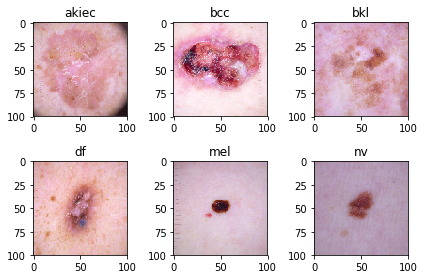

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

names = list(pd.get_dummies(df['dx']).columns)

fig, ax = plt.subplots(nrows = 2, ncols = 3)
k = 0
r = np.random.randint(len(x_train), size = 6)
v = np.unique(np.where(y_train == 1)[1],return_index = True)[1]
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(x_train[v[k]] / 255.)
        c = np.argmax(y_train[v[k]])
        ax[i][j].set_title(names[c])
        k += 1
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4, 5, 6]),
 array([6704, 1695,    0,  755,  838,   45, 1595]))

Since we're dealing with only 7000 training examples we will augment the images by various transformations to create a larger dataset

In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            rotation_range=30,
            zoom_range=0.2,
            horizontal_flip=False,
            vertical_flip=False,
            width_shift_range=0.2,
            height_shift_range=0.2,
    )

train_gen.fit(x_train)
tg_flow = train_gen.flow(x_train,y_train, batch_size=1, shuffle = True)

We visualize the transformations. 

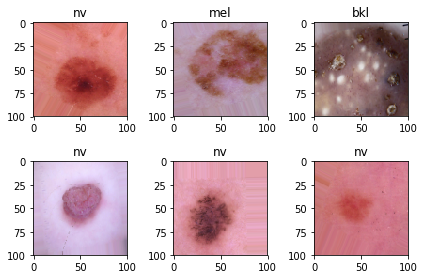

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 3)
for i in range(2):
    for j in range(3):
        a_new = tg_flow.next()
        name = np.argmax(a_new[1])
        
        ax[i][j].imshow(a_new[0][0] / 255.)
        ax[i][j].set_title(names[name])
plt.tight_layout()
plt.show()

For training, we look at a number of models. We start of with a small convolutional net of 2 sets of convlutional layers with max pooling and dropout in between. 

The models follow a similar architecture. We start with a set of larger 5x5 convolutional filters which capture low dimensional features such as edges and colors. This is followed by a set of 3x3 filters which capture more detailed features. This convolutional block is followed by max pooling which reduces the dimension of the image and acts a regularizer. We then follow the same pattern again but this time increasing the number of filter to be able to capture high dimensional features in the top layers. Each conv block is followed by dropout of varying probabilities.  

We also experiment with residual connections and batch normalization between the blocks. 

In [218]:
import keras
from keras.models import load_model
import glob
results = glob.glob('saved_models/*')

small_model = results[-1]
model = load_model(small_model + '/model.h5')

In [272]:
results = glob.glob('saved_models/*')
results

['saved_models/MEDIUM_MODEL_0_10_T_14-57',
 'saved_models/BIG_MODEL_0_10_T_16-15',
 'saved_models/MEDIUM2_0_10_T_15-48',
 'saved_models/BIG_MODEL_0_10_T_15-0',
 'saved_models/MED_RES_0_10_16_T_18-23',
 'saved_models/MEDIUM2_0_10_T_16-3',
 'saved_models/MED_RES_0_10_64_T_18-29',
 'saved_models/SMALL_MODEL_0_10_T_14-30']

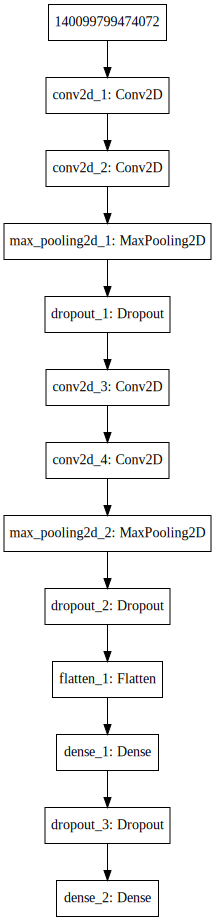

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

We look at the training and validation accuracy during training. The disrepency between the validation accuracy and the training accuracy can possibly be explained by differences between the training and validation split that arise because the classes are unbalanced. 

In [19]:
import deepdish as dd
training_err = dd.io.load(small_model + '/model_val_history.h5')
final_scores = dd.io.load(small_model + '/model_scores.h5')

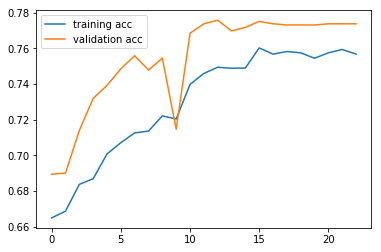

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(training_err['acc'], label = 'training acc')
plt.plot(training_err['val_acc'], label = 'validation acc')
plt.legend()
plt.show()

In [ ]:
#Normalize
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
x_test = (x_test - np.mean(x_train, axis = (0,1,2)))/255.*2

model = load_model(small_model + '/model.h5')
preds = model.predict(x_test)


A confusion matrix tells us a little bit more about our model predictions. Row i corresponds to the correct class and columns j correspond to predicted values. The second biggest classes, mel and bkl are classified as nv in a signficant amount of the test samples. Since nv is the largest class, our model places a high prior on this class and our model converges to predicting mostly this class, since it will atleast achieve a 66% accuracy with this method. 

Text(0.5, 0.98, 'Small model')

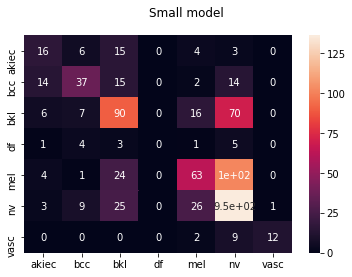

In [99]:
import seaborn as sns
conf = confusion_matrix(np.argmax(y_test,1), np.argmax(preds,1))
sns.heatmap(conf, annot = True, robust = True, xticklabels = names, yticklabels = names)
plt.suptitle('Small model')


In [213]:
np.sum(y_train,0)

array([ 240,  355,  756,   82,  761, 4651,  100], dtype=uint64)

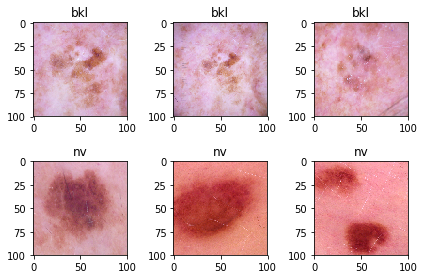

In [214]:
#v = np.unique(np.where(y_train == 1)[1],return_index = True)[1]
a = np.where((y_train == [0,0,1,0,0,0,0]).all(1))[0]
b = np.where((y_train == [0,0,0,0,0,1,0]).all(1))[0]
fig, ax = plt.subplots(nrows = 2, ncols = 3)

k = 0
for i in range(2):
    if i == 0:
        d = a
    else:
        d = b
    for j in range(3):
        ax[i][j].imshow(x_train[d[k]] / 255.)
        c = np.argmax(y_train[d[k]])
        ax[i][j].set_title(names[c])
        k += 1
plt.tight_layout()
plt.show()

We also train a larger network with a similar architecture to the small model but with one added convolutional block

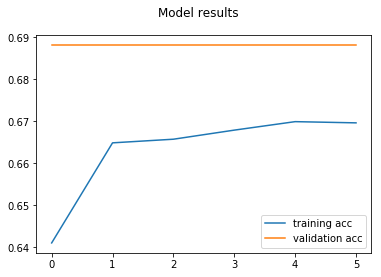

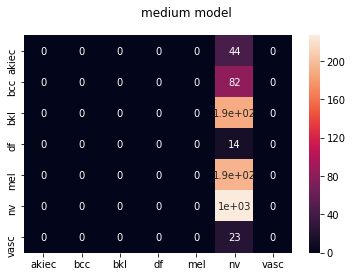

[1.0400899271132162, 0.6506717850287908]

In [273]:
medium_model = results[2]
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
def get_scores(model_name, mn):
    model = load_model(model_name + '/model.h5')
    SVG(model_to_dot(model).create(prog='dot', format='svg'))
    training_err = dd.io.load(model_name + '/model_val_history.h5')
    final_scores = dd.io.load(model_name + '/model_scores.h5')

    preds = model.predict(x_test)
    
    plt.plot(training_err['acc'], label = 'training acc')
    plt.plot(training_err['val_acc'], label = 'validation acc')
    plt.suptitle('Model results')
    plt.legend()
    plt.show()
    
    conf = confusion_matrix(np.argmax(y_test,1), np.argmax(preds,1))
    sns.heatmap(conf, annot = True, robust = True, xticklabels = names, yticklabels = names)
    plt.suptitle(mn)
    plt.show()
    
    return final_scores

get_scores(medium_model, 'medium model')


In [122]:
results = glob.glob('saved_models_4/*')
results.pop(-2)
#Different normalization
x_test = np.load(data_dir + '/x_im_test.npy')
x_test = x_test/127.5 - 1

We try several other models. 
We try to mitigate our class imbalance by placing a larger error on missclassified samples from the minority classes. This results in a sharp decrease in accuracy and lesser performance. Class weights is another hyperparameter that should be tuned more for more accurate results. 

We note that larger models perform worse than smaller ones as in the example above. This can perhaps be expected since the dataset is quite small but even during training, larger models fail to converge while in theory they should be able to fit the training set better. We try to mitigate this by adding residual connections and batch normalization and see if there is an improvement.

Bigger models and a pretrained VGG were also trained but failed to converge to any meaningful result. VGG net is trained on imagenet which could perhaps be too different from our dataset. Even using just the first layers of the model which capture low dimensional features didn't prove fruitful. 

In [260]:
results1 = glob.glob('saved_models_2/*')
results2 = glob.glob('saved_models_4/*')
results3 = [results1[2], results1[-1]] + results2
results3

['saved_models_2/MINI_0_10_16_T_21-40',
 'saved_models_2/SMALL_MODEL_1_10_16_T_21-25',
 'saved_models_4/MEDIUM2_0_10_16_T_12-38',
 'saved_models_4/MED_RES_0_10_16_T_12-55',
 'saved_models_4/MEDIUM_MODEL_0_10_16_T_12-45']

In [262]:
from collections import defaultdict
k = 0
d = defaultdict(list)
for k in range(len(results3)):
    model = load_model(results3[k] + '/model.h5')
    final_scores = dd.io.load(results3[k] + '/model_scores.h5')
    preds = model.predict(x_test)
    d[results3[k]].append(preds)
    conf = confusion_matrix(np.argmax(y_test,1), np.argmax(preds,1))
    d[results3[k]].append(conf)


In [244]:

model_names = ['MEDIUM, no class_weights',
              'MEDIUM, class_weights, batch_norm',
              'Smallest model, no class weights',
              'Medium residual connections, no class weights',
               'medium model, batch norm',
              'Small model with class weights']

name_table = dict(zip(results,model_names))

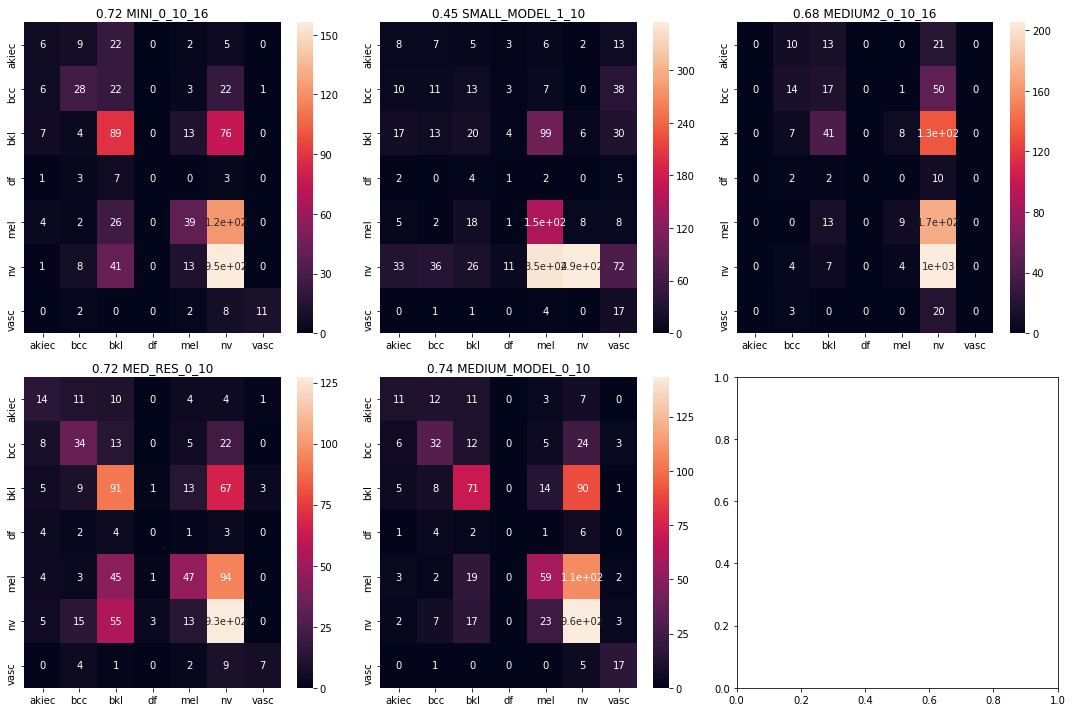

In [269]:
fig,ax = plt.subplots(nrows = 2, ncols =3, figsize = (15,10))

k = 0
for i in range(2):
    for j in range(3):
        if k >= len(results3):
            break
        final_scores = dd.io.load(results3[k] + '/model_scores.h5')
        conf = d[results3[k]][1]
        sns.heatmap(conf, annot = True, robust = True, xticklabels = names, yticklabels = names, ax = ax[i][j])
        ax[i][j].set_title('{:.2f} '.format(final_scores[1]) + '_'.join(results3[k].split('/')[1].split('_')[0:4]))
        k += 1

plt.tight_layout()
plt.show()

The top small model weighs each class equally. This places very high error on missclassifying the smaller classses. The effect of weighing classes is most apparent in three instances. The missclassifications of class bkl has moved from nv to mel and similarly class nv is more drawn to be classified as mel as well. A big difference is that class mel is also correctly classified at a larger rate than before. This has two implications. First, we will see a decrease in accuracy of our model since the predictions aren't dominated by class nv as before. Secondly, mel could be a more horrifying type of cancer than nv. An increase in false positives on class mel may be worth it. Weighing the classes in our model by weighing both by the number of samples and the severity of the cancer could result in a better model overall.

We see that the MEDIUM2 model in the top right corner mostly classifies everything as belonging to class nv. This is not apparent in the lower medium models which  give give more diverse classifications. The only difference between these two are batch normalizationa and BN + residual connections. We see that these two modifications help the network to not overfit to one class. 

Future work:
    We can combine our trained model on the images with the tabular data to try to improve our model
    
    More image augmentation on minority classes to oversample them
    

In [ ]:
import os
from keras.layers import Dense, Input
from keras.models import Model

x_feat_train = np.load(data_dir + '/x_feat_train.npy')
x_feat_test = np.load(data_dir + '/x_feat_test.npy')

model_name = 'saved_models_2/MEDIUM_MODEL_0_10_16_T_21-3'
model = load_model(model_name + '/model.h5')
for layer in model.layers:
    layer.trainable = False

#pop last layer
model.layers.pop()

inp1 = model.input
cnn_out = model(inp1)


inp2 = Input(shape = (23,), name = 'aux_input')
x = Dense(32, activation = 'relu')(inp2)
x = keras.layers.concatenate([x, cnn_out])
x = Dense(128, activation = 'relu')(x)
x = Dense(7, activation = 'softmax')(x)

combined_model = Model(inputs = [inp1, inp2], outputs = x)
combined_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#combined_model.fit([x_train, x_feat_train], y_train, epochs = 10, batch_size = 32)

#save_dir = 'saved_combined_models/'
#if not os.path.exists:
#    os.mkdir(save_dir)
#combined_model.save(save_dir + models[i])